## Initialize Input Files for IPMOF (initialize_IPMOF.py)

### Initialize necessary information

1. Read FF_Parameters excel file to get force field parameters for atoms
2. Initialize force field selection, cutOff radius and grid size for energy map

### Create input files for MOF files in a given directory
1. Reaf MOF files in ".mol2" format from given directory and create a list
2. Choose the first MOF1 as the stationary (map) MOF, initialize its variables, and calculate packed coordinates
3. For all the MOFs in the list:
4. Initialize MOF2 variables for the mobile MOF
5. Calculate energy map
6. Export energy map -> .json
7. Export MOF2 structure information -> .json

In [1]:
import math
import os
os.chdir('C:\\Kutay\\IPMOF')
from energyMapFunctions import *

excelFileDir = 'C:\\Users\\kutay\\iPython\\IPMOF\\FF_Parameters.xlsx'
UFF = readFFparameters(excelFileDir, 'UFF')

# Read radius list from the excel file
radiusList = readAtomRadius()

# Generate MOF list
fileDir = 'C:\\Users\kutay\\Desktop\\REFmol2'
fileFormat = ".mol2"
MOFlist = generateMOFlist(fileDir, fileFormat)
MOFnames = []

#cutOff = 13
orthoCount = 0
VFtotal = 0
MOFs = []
for MOFindex, mof in enumerate(MOFlist):
    newMOF = MOF()
    newMOF.dir = fileDir + '\\' + mof
    newMOF.file = open(newMOF.dir, 'r')
    newMOF.initialize()
    
    # Calculate void fraction
    atomVolumes = atomicVolume(newMOF, radiusList)
    UnitCellVolume = ucv(newMOF)
    newMOF.UCV = UnitCellVolume
    newMOF.atomDensity = atomVolumes / UnitCellVolume
    newMOF.voidFraction = 1 - atomVolumes / UnitCellVolume
 
    # Calculate packing for base MOF
    widthA = newMOF.UCV / (newMOF.UCsize[1]*newMOF.UCsize[2] / math.sin(math.radians(newMOF.UCangle[0])))
    widthB = newMOF.UCV / (newMOF.UCsize[0]*newMOF.UCsize[2] / math.sin(math.radians(newMOF.UCangle[1])))
    widthC = newMOF.UCV / (newMOF.UCsize[0]*newMOF.UCsize[1] / math.sin(math.radians(newMOF.UCangle[2])))
    newMOF.cutOff = min(widthA/2, widthB/2, widthC/2)
    packingFactor = Packing.factor(newMOF.UCsize, newMOF.cutOff)
    newMOF.packingFactor = packingFactor
    translationVectors, UCvectors = Packing.vectors(packingFactor, newMOF.UCsize, newMOF.UCangle)
    newMOF.packedCoor = Packing.UC(translationVectors, packingFactor, UCvectors, newMOF.atomCoor)
    newMOF.edgePoints = Packing.edgePoints(UCvectors)
    
    if newMOF.voidFraction > 0.94:
        MOFname = MOFlist[MOFindex].split('.')[0]
        MOFname = MOFname.split('_')[0]
        newMOF.name = MOFname
        MOFs.append(newMOF)
        VFtotal += newMOF.voidFraction
        orthoCount += 1 

VFaverage = VFtotal / orthoCount
    
print('Vf > 0.94 MOF count: ' + str(orthoCount))
print('Average Void Fraction: ' +str(VFaverage))

Vf > 0.94 MOF count: 60
Average Void Fraction: 0.9492591508735512


In [4]:
targetVF = 0.94
refinedMOFs = []
refinedCount = 0
table = []
identicalMOFs = []
counterpartMOFs = []
for mofIndex, mof in enumerate(MOFs):
    if mof.voidFraction > targetVF:
        mof.initializeFF(UFF)
        #foundIdentical = False
        if mofIndex > 0:
            for refMOF in refinedMOFs:
                if round(mof.voidFraction, 2) == round(refMOF.voidFraction, 2):
                    if sorted(refMOF.uniqueAtomNames) == sorted(mof.uniqueAtomNames):
                        #if not foundIdentical:
                            identicalMOFs.append(mof)
                            counterpartMOFs.append(refMOF.name)
                            #foundIdentical = True
        refinedMOFs.append(mof)
        table.append([])
        table[refinedCount].append(mof.name)
        table[refinedCount].append(mof.uniqueAtomNames)
        table[refinedCount].append(mof.UCsize)
        table[refinedCount].append(mof.UCangle)
        table[refinedCount].append(round(mof.voidFraction, 2))
        table[refinedCount].append(round(mof.cutOff, 2))
        #table[refinedCount].append(mof.packingFactor)
        refinedCount += 1
#del MOFs
        
from tabulate import tabulate

headers = ["MOF Name", "Atoms", "UCsize", "UCangle", "VF", "Cut-Off"]
print(tabulate(table, headers))

MOF Name      Atoms                             UCsize                       UCangle                          VF    Cut-Off
------------  --------------------------------  ---------------------------  -----------------------------  ----  ---------
ALAMUW        ['H', 'C', 'N', 'O', 'Cu']        [18.794, 18.794, 19.9351]    [61.8761, 61.8761, 60.0]       0.96       6.02
ANOMUM        ['O', 'Cu', 'H', 'C', 'N']        [10.3036, 15.2248, 20.4069]  [111.9026, 104.6228, 90.0]     0.96       4.27
BAKJII        ['H', 'O', 'Co', 'C', 'N']        [11.85, 13.853, 13.944]      [90.0, 114.793, 90.0]          0.94       5.38
BEPRIZ        ['H', 'C', 'O', 'Co', 'N']        [18.9, 18.9, 18.9]           [61.8682, 61.8682, 61.8682]    0.94       6.14
BICDAU        ['H', 'C', 'N', 'Zn']             [17.75, 17.75, 19.192]       [90.0, 90.0, 120.0]            0.95       7.2
BIFKEI        ['H', 'C', 'N', 'Cu', 'Cl', 'O']  [12.287, 12.916, 18.199]     [86.733, 70.443, 80.146]       0.94       5.65
BUKMUQ   

In [5]:
for mof, cmof in zip(identicalMOFs, counterpartMOFs):
    print(mof.name +'\t' + cmof)

print('-----------------------------------------------------')
print('Refined MOFs: ' + str(len(refinedMOFs)) + ' Identical MOFs: ' + str(len(identicalMOFs)))
print('Non-identical MOFs: ' + str(len(refinedMOFs) - len(identicalMOFs)))

nonidenticalMOFs = []
discardMOFs = []

   
for refMOF in refinedMOFs:
    if refMOF.name not in list(counterpartMOFs):
        nonidenticalMOFs.append(refMOF)

print('-----------')
print('Non-identical MOF count: ' + str(len(nonidenticalMOFs)))
for nonMOF in nonidenticalMOFs:
    print(nonMOF.name)
    
refinedMOFs = []
refinedMOFs = nonidenticalMOFs

ANOMUM	ALAMUW
BEPRIZ	BAKJII
COGWEB	BUKMUQ
EDOMAM	ALAMUW
EDOMAM	ANOMUM
FUTKEL	DEYVUA
GALBUS	FEWTUY
GIYTIS	BUKMUQ
GIYTIS	COGWEB
HEGJUZ	DEYVUA
HEGJUZ	FUTKEL
HIHNUJ	FAYKOH
IYIHUU	FUNBOG
LUVTEC	BUKMUQ
LUVTEC	COGWEB
LUVTEC	GIYTIS
MATVAF	BUKMUQ
MATVAF	COGWEB
MATVAF	GIYTIS
MATVAF	LUVTEC
MICNUI	MICNIW
MICPAQ	MICNIW
MICPAQ	MICNUI
MOCKEV	IXAKAU
NAQLAT	BUKMUQ
NAQLAT	COGWEB
NAQLAT	GIYTIS
NAQLAT	LUVTEC
NAQLAT	MATVAF
NEHNEV	BUKMUQ
NEHNEV	COGWEB
NEHNEV	GIYTIS
NEHNEV	LUVTEC
NEHNEV	MATVAF
NEHNEV	NAQLAT
PEVQOY	PEVQIS
QUQFIS	MUZHUL
TONQOD	IRMOF-7
UNIGEE	PEVQIS
UNIGEE	PEVQOY
VUSJUP	IRMOF-7
VUSJUP	TONQOD
XAWVUN	ALAMUW
XAWVUN	ANOMUM
XAWVUN	EDOMAM
XINFUW	MUZHUL
XINFUW	QUQFIS
ZIKJIO	ALAMUW
ZIKJIO	ANOMUM
ZIKJIO	EDOMAM
ZIKJIO	XAWVUN
ZIKJOU	IXAKAU
ZIKJOU	MOCKEV
-----------------------------------------------------
Refined MOFs: 60 Identical MOFs: 53
Non-identical MOFs: 7
-----------
Non-identical MOF count: 34
BEPRIZ
BICDAU
BIFKEI
CEKHIL
COF-300
COF-5
CUYWUP
DEPXIG
GALBUS
GINLIA
GUNFAW01
HEGJUZ
HIGRIA
HIHNUJ
IXAJ

In [6]:
# Creates atom list for non-repeating atoms from a list of MOF classes
atomList = getUniqueAtomList(refinedMOFs)

# Creates atom list required in the energy map of a combination of MOFs
eMapAtomList = getEnergyMapAtomList(refinedMOFs, atomList)

# Directory and format to export energy map and MOF structure files
exportFolder = "C:\\Kutay\\IPMOF_Input"
exportFormat = ".js"

for MOFindex, mof in enumerate(refinedMOFs):  
           
    # Create export directory for the base MOF and create folder
    exportMOFfolder = os.path.join(exportFolder, mof.name)
    os.mkdir(exportMOFfolder)
    
    # --------------------- Calculate Energy Map -------------------
    # For each MOF energy map is calculated with an atom list that consists of all the unique atoms z
    # for a given list of MOFs
    eMap = energyMap(mof, atomList, mof.cutOff, 1)
    
    avgEnergyLimits = calculateEnergyLimits(MOFindex, refinedMOFs, MOFlist, eMapAtomList, eMap)
    
    for MOFindex2, mof2 in enumerate(refinedMOFs):
        
        if MOFindex2 >= MOFindex:        
            # Create export directory for the mobile MOF and create folder
            exportMOFfolder2 = os.path.join(exportMOFfolder, mof2.name)
            os.mkdir(exportMOFfolder2)

            # Create export directory for mobile MOF
            exportDir_MOF = os.path.join(exportMOFfolder2, mof2.name + exportFormat)
            exportGLOBALMOFjs(mof2, exportDir_MOF)
            print(exportDir_MOF.split("\\")[-1] + ' is exported')

            # Create export directory for energy map
            exportDir_eMap = os.path.join(exportMOFfolder2, mof.name + '+' + mof2.name + '_eMap' + exportFormat)
            exportGLOBALEnergyMapjs(eMap, avgEnergyLimits[MOFindex2], eMapAtomList, MOFindex2, exportDir_eMap)
            print(exportDir_eMap.split("\\")[-1] + ' is exported')

            # Export base MOF structure
            exportDir_baseMOF = os.path.join(exportMOFfolder2, 'base' + mof.name + exportFormat)
            exportGLOBALBaseMOFjs(refinedMOFs[MOFindex], exportDir_baseMOF)
            print(exportDir_baseMOF.split("\\")[-1] + ' is exported')

MOF Name        Atoms                               Average Energy Limit
--------------  --------------------------------  ----------------------
ABAVIJ_clean    ['O', 'H', 'C', 'N', 'Co']                   4.05117e+12
ABAVOP_clean    ['Zn', 'H', 'C', 'N']                        4.90008e+12
ABEXIQ_clean    ['Cl', 'O', 'H', 'C', 'N', 'Cu']             6.95879e+12
ABEXOW_clean    ['O', 'H', 'C', 'N', 'Co']                   4.05117e+12
ABEXUC_clean    ['H', 'C', 'N']                              6.07695e+12
ABEYAJ_clean    ['O', 'H', 'C', 'B']                         4.90008e+12
ABEYIR          ['O', 'H', 'C', 'Cu']                        4.90008e+12
ABIYIV          ['O', 'Mn', 'H', 'C', 'N']                   4.05117e+12
ABUWOJ_clean    ['O', 'H', 'C', 'N', 'Ni']                   4.05117e+12
ACAKUM          ['Cl', 'O', 'Zn', 'H', 'C']                  4.05117e+12
ACALIB_clean    ['O', 'Mn', 'C', 'Cr']                       4.90008e+12
ACODED          ['O', 'Zn', 'H', 'C', 'N']         

In [7]:
# Calculate Energy Map
# eMap = energyMap(MOF2, atomList, cutOff, 1)

#plotEnergyMap(eMap, 90, 0)
#plotPackedCell(MOF2.packedCoor, 90, 0)

# Create export directory for the energy map
#MOFname = MOFlist[MOFselection].split('.')[0]
#MOFname = 'MOFX'
#exportFolder = "C:\\Users\\kutay\\iPython\\IPMOF\\multipleMOF"
#exportFormat = ".js"
#exportDir_eMap = os.path.join(exportFolder, MOFname + '_eMap' + exportFormat)
#exportDir_MOF = os.path.join(exportFolder, MOFname + exportFormat)
#print(exportDir_eMap)
#print(exportDir_MOF)

#eMapDir = "C:\\Users\\kutay\\iPython\\IPMOF\\eMap.js"
#exportEnergyMapjs(eMap, atomList, exportDir_eMap)

#MOFexportDir = "C:\\Users\\kutay\\iPython\\IPMOF\\MOF.js"
#exportMOFjs(MOF2, exportDir_MOF)

len(MOFs[6].atomCoor)

424

Populating the interactive namespace from numpy and matplotlib


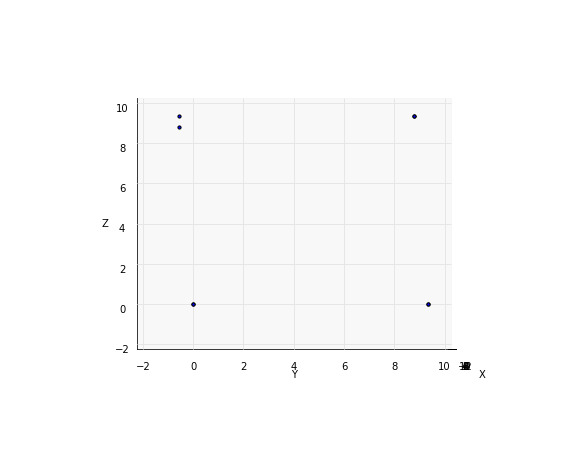

In [6]:
%pylab inline
plotXYZ(UCedges,0,0)

In [33]:
import math
coor = [-25, 21, 34]
UCsize = [6, 16, 8]
UCangle = [90, 90, 90]


def car2frac(coor, UCsize, UCangle, UCV):
    
    alp = UCangle[0] / 180 * math.pi
    bet = UCangle[1] / 180 * math.pi
    gam = UCangle[2] / 180 * math.pi
    
    a = UCsize[0]
    b = UCsize[1]
    c = UCsize[2]
    
    x = coor[0]
    y = coor[1]
    z = coor[2]
    
    v = math.sqrt(1 - math.cos(alp)**2 - math.cos(bet)**2 - math.cos(gam)**2 + 2*math.cos(alp)*math.cos(bet)*math.cos(gam))
    
    xfrac = 1/a*x 
    xfrac += - math.cos(gam)/(a*math.sin(gam))*y 
    xfrac += (math.cos(alp)*math.cos(gam)-math.cos(bet))/(a*v*math.sin(gam))*z
    
    yfrac = 0
    yfrac += 1/(b*math.sin(gam))*y
    yfrac += (math.cos(bet)*math.cos(gam)-math.cos(alp))/(b*v*math.sin(gam))*z
    
    zfrac = 0
    zfrac += 0
    zfrac += math.sin(gam)/(c*v)*z
    
    return [xfrac, yfrac, zfrac]

def fracPBC(fracCoor):
    pbcCoor = []
    for coor in fracCoor:
        pbcCoor.append(coor - math.floor(coor))
    return pbcCoor


fracCoor = car2frac(coor, UCsize, UCangle, ucv)
print(fracCoor)
pbcCoor = fracPBC(fracCoor)
print(pbcCoor)

[-4.166666666666666, 1.3124999999999998, 4.25]
[0.8333333333333339, 0.3124999999999998, 0.25]


In [23]:
a = ['sd', 'sdsdds', 'dsdfgg']

'sd' not in a

False

In [9]:
refinedMOFs[8].edgePoints

[[0, 0, 0],
 [12.8597, 0, 0],
 [9.258758427933692e-16, 15.1207, 0],
 [1.4399397064374577e-15, 1.439939706437458e-15, 23.516],
 [12.859700000000002, 15.1207, 0],
 [2.365815549230827e-15, 15.120700000000001, 23.516],
 [12.859700000000002, 1.439939706437458e-15, 23.516],
 [12.859700000000004, 15.120700000000001, 23.516]]

In [11]:
refinedMOFs[10].edgePoints

[[0, 0, 0],
 [18.1424, 0, 0],
 [9.071200000000001, 15.711779285618798, 0],
 [9.071200000000001, 5.237259761872932, 14.813207569823174],
 [27.2136, 15.711779285618798, 0],
 [18.142400000000002, 20.94903904749173, 14.813207569823174],
 [27.2136, 5.237259761872932, 14.813207569823174],
 [36.284800000000004, 20.94903904749173, 14.813207569823174]]

In [7]:
math.radians(30)

0.5235987755982988